In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve, auc



from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier , RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis  
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb  


import shap
import lime
from lime import lime_tabular
import random

from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

In [2]:
dataSetIndex = 4
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ] 
'''
dataSetResultDirectory += ("DatasetResults_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += " {}".format(fileData.shape)
'''

X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))




Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number o

In [ ]:

finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score', 'AUC'], ]

In [ ]:

columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []
for column in columns:
    singleColumnCount = fileData[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 
tableDataRow = [ ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'], ]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = fileData[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

 
# Determine the number of rows in the table (excluding the header)
num_rows = len(tableDataRow) + 1
# Calculate the desired figure size based on the number of rows
fig_width = 6  # Set the desired width of the figure
fig_height = num_rows * 0.5  # Adjust the scaling factor to control the height

fig, ax = mplot.subplots(figsize=(fig_width, fig_height)) 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_column_width(col=list(range(len(tableDataRow[0]))))



table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 

dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, fileData.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(fileData[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[0], (np.array(fileData[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[1], (np.array(fileData[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.10,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.02,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, -0.06,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.14,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   

remarks = "You need to distribute the target class in equal number of records in training-set."
#fig.text(-0.2, -0.15,  remarks, horizontalalignment='left', wrap=True ,fontsize=12, fontweight='bold' )   
 
mplot.axis('off')
mplot.title(f'Exploring Dataset - {dataSetName}' ,fontsize=16, fontweight='bold') 
picturePath = "{}0.DataSet_analysis_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig(picturePath,  dpi=300 )
mplot.show()
mplot.close()


 

In [3]:
def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(10, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName)  ,fontsize=16, fontweight='bold')
    
    picturePath = "{}0.1_Correlation_Matrix_DateSetName_{}.png".format(dataSetResultDirectory, dataSetName)
    
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()
def plot_classification_report(title, dataSetName, y_tru, y_prd, figsize=(6, 6), ax=None):
    #mplot.figure(figsize=figsize)
    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = ['Healthy', 'Heart Disease']
    rep = np.array( precision_recall_fscore_support(y_tru, y_prd) ).T
    rep[0][0] *= 100.0
    rep[0][1] *= 100.0
    rep[0][2] *= 100.0
    rep[1][0] *= 100.0
    rep[1][1] *= 100.0
    rep[1][2] *= 100.0
    
    ax = sns.heatmap(rep, annot=True, cmap='Blues', cbar=False, xticklabels=xticks, yticklabels=yticks)
    ax.set_title("Classification Report {} Model\n\n".format(title) ,fontsize=16, fontweight='bold')
    ax.set_xlabel('\nDataset:{}'.format(dataSetName))
    ax.xaxis.set_ticklabels(xticks)
    ax.set_ylabel('Classes')
    ax.yaxis.set_ticklabels(yticks)
    
    picturePath = "{}ClassificationReport_{}_{}.png".format(dataSetResultDirectory, title, dataSetName) 
    mplot.savefig(picturePath, dpi=300, bbox_inches='tight')
    #os.startfile(picturePath)
    mplot.close()
def makeConfusionMatrixPic(fileID, method, dataSet, classifierObj , X_test, y_test, predicted_Y):
    display = ConfusionMatrixDisplay.from_predictions(y_test,predicted_Y, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method) ,fontsize=16, fontweight='bold')
    display.ax_.set_xlabel('\nPredicted Values')
    display.ax_.set_ylabel('Actual Values ') 
 
    accuracyValue = (accuracy_score(y_test, predicted_Y)*100.0) 
    recallValue = (recall_score(y_test, predicted_Y, average='weighted') * 100.0)
    precisionValue = (precision_score(y_test, predicted_Y) * 100.0) 
    f1Score = (f1_score(y_test, predicted_Y, average='weighted') * 100.0)

 
    singleRowInTable = [] 
    singleRowInTable.append(fileID)
    singleRowInTable.append(method)
    singleRowInTable.append("{:.2f}".format(accuracyValue) )
    singleRowInTable.append("{:.2f}".format(recallValue) )
    singleRowInTable.append("{:.2f}".format(precisionValue) )
    singleRowInTable.append("{:.2f}".format(f1Score) )
    singleRowInTable.append("-")

    finalResultTable.append((singleRowInTable) )


    accuracyString ="Accuracy : {:.2f} %".format( accuracyValue) 
    recallString =  'Recall : {:.2f} %'.format(recallValue)
    precisionString = 'Precision : {:.2f} %'.format(precisionValue) 
    precisionString = 'Precision : {:.2f} %'.format(precisionValue) 
    f1String = 'F1 Score : {:.2f} %'.format(f1Score) 
    dataSetString = "Dataset: {}".format(dataSet)
    
    numberOfTrainingRecords = "No of Training Records: {}  {:.2f} %".format(len(X_train), ((len(X_train)/totalRecords) * 100.0))
    numberOfTestingRecords = "No of Testing Records: {}  {:.2f} %".format(len(X_test), ((len(X_test)/totalRecords) * 100.0))


    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False , fontsize=12 )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False , fontsize=12 )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.17,  f1String, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.21,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.25,  numberOfTrainingRecords, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.29,  numberOfTestingRecords, horizontalalignment='left', wrap=False , fontsize=12 ) 
    
    '''
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    '''
    
    picturePath = "{}{}.Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, fileID, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()


def makeConfusionMatrixPicWithProbibality(fileID, method, dataSet, classifierObj , X_test, y_test, predicted_Y):
    display = ConfusionMatrixDisplay.from_predictions(y_test,predicted_Y, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method) ,fontsize=16, fontweight='bold')
    display.ax_.set_xlabel('\nPredicted Values')
    display.ax_.set_ylabel('Actual Values ') 

    predicted_Proba = classifierObj.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, predicted_Proba)
    roc_auc = auc(fpr, tpr) 

    accuracyValue = (accuracy_score(y_test, predicted_Y)*100.0) 
    recallValue = (recall_score(y_test, predicted_Y, average='weighted') * 100.0)
    precisionValue = (precision_score(y_test, predicted_Y) * 100.0) 
    f1Score = (f1_score(y_test, predicted_Y, average='weighted') * 100.0)

 
    singleRowInTable = [] 
    singleRowInTable.append(fileID)
    singleRowInTable.append(method)
    singleRowInTable.append("{:.2f}".format(accuracyValue) )
    singleRowInTable.append("{:.2f}".format(recallValue) )
    singleRowInTable.append("{:.2f}".format(precisionValue) )
    singleRowInTable.append("{:.2f}".format(f1Score) )
    singleRowInTable.append("{:.2f}".format(roc_auc) )

    finalResultTable.append((singleRowInTable) )


    accuracyString ="Accuracy : {:.2f} %".format( accuracyValue) 
    recallString =  'Recall : {:.2f} %'.format(recallValue)
    precisionString = 'Precision : {:.2f} %'.format(precisionValue) 
    precisionString = 'Precision : {:.2f} %'.format(precisionValue) 
    f1String = 'F1 Score : {:.2f} %'.format(f1Score) 
    dataSetString = "Dataset: {}".format(dataSet)
    
    numberOfTrainingRecords = "No of Training Records: {}  {:.2f} %".format(len(X_train), ((len(X_train)/totalRecords) * 100.0))
    numberOfTestingRecords = "No of Testing Records: {}  {:.2f} %".format(len(X_test), ((len(X_test)/totalRecords) * 100.0))


    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False , fontsize=12 )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False , fontsize=12 )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.17,  f1String, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.21,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.25,  numberOfTrainingRecords, horizontalalignment='left', wrap=False , fontsize=12 ) 
    display.figure_.text(0.010, -0.29,  numberOfTestingRecords, horizontalalignment='left', wrap=False , fontsize=12 ) 
    
    '''
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False , fontsize=12 ) 
    '''
    
    picturePath = "{}{}.Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, fileID, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()



def makeLIMEreport(method, classifierObj):
    class_names =  ['Healthy', 'Heart Disease']
    listOfFeatures =  classifierObj.feature_names_in_
    print("\n\n\n Obj Features: {}, len: {} \n\n".format(listOfFeatures, len(listOfFeatures)))
    #explainer = lime_tabular.LimeTabularExplainer(np.array(X_train) , mode='regression', feature_names=listOfFeatures, verbose=True, class_names=class_names )
    explainer = lime_tabular.LimeTabularExplainer(np.array(X_train) , mode='classification', feature_names=listOfFeatures, verbose=True, class_names=class_names )

    num_instances = int(len(X_test)/4)
    print("num_instances: {}".format(num_instances))
    # Generate explanations for each testing instance
    explanations = []
    for i in range(num_instances):
        instan = instance[i]
        explanation = explainer.explain_instance(instan, classifierObj.predict_proba, num_features=len(instan))
        explanations.append(explanation)

    #Extract the feature importance values from the explanations
    feature_importances = np.mean([exp.as_map()[1] for exp in explanations], axis=0)
    averageF = []
    for singleFeature in feature_importances:
        averageF.append(singleFeature[0])
     
    print("\n\nfeature_list:{}".format(listOfFeatures))
    print("averageF:{} \n\n".format(averageF))


    fig, ax = mplot.subplots()
    ax.barh(listOfFeatures, averageF )
    ax.set_ylabel('Feature List')
    ax.set_xlabel('Average Importance')
    ax.set_title("XAI LIME ({} Model)".format(method) ,fontsize=16, fontweight='bold')
     
    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of Testing Set: {}".format(len(X_test))
    explainerModelString = "LIME Explainer Model: {}".format(explainer.mode)
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  explainerModelString, horizontalalignment='left', wrap=False )   
 

    picturePath = "{}XAI_LIME_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()
def makeSHAPreport(method, model):
    shap_explainer = shap.Explainer(model, X_train) 
    shap_values = shap_explainer.shap_values(X_test)  
    shap.summary_plot(shap_values, X_test, show=False)
    ax = mplot.gca() 
    ax.set_title("XAI SHAP Explainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')     

    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of Testing Set: {}".format(len(X_test))
    shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

    picturePath = "{}XAI_SHAP_Explainer_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    mplot.show()
    #os.startfile(picturePath)
    mplot.close()
def makeSHAP_KERNELreport(method, model):
    shap_explainer = shap.KernelExplainer(model.predict_proba, X_train) 
    testingShape = X_test[0:10]
    shap_values = shap_explainer.shap_values(testingShape)  
    shap.summary_plot(shap_values, X_test, show=False)
    ax = mplot.gca() 
    ax.set_title("XAI SHAP KernelExplainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')     

    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of Testing Set: {}".format(len(testingShape))
    shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

    picturePath = "{}XAI_SHAP_KernelExplainer_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    mplot.show()
    #os.startfile(picturePath)
    mplot.close()
   

In [ ]:
# Calculate the correlation matrix 
correlation_matrix = fileData.corr()
#makeCorrelationPic(correlation_matrix, 15, 'CoronaryHeartDisease') 

makeCorrelationPic(correlation_matrix, 15, fileData.__dataframe__().column_names()[-1] ) 

In [ ]:
import pandas as pd
column_names = X.columns

#print("columns of x:: {} \n and features of X: {} \n\n".format(len(column_names), column_names))

# Apply PCA
pca = PCA(n_components=6)
pca.fit(X, Y)
X_pca = pca.fit_transform(X)

# Get the selected column indices
selected_columns_indices = pca.components_ #.argsort()[:-1][:pca.n_components_]

# Get the selected column names
#selected_columns = column_names[selected_columns_indices]

pd2 = pd.DataFrame(X_pca, columns=["col1", "col2", "col3", "col4", "col5", "col6" ])
#pd3 = pd.DataFrame(Y, columns=[fileData.__dataframe__().column_names()[-1]]) 
pd2[fileData.__dataframe__().column_names()[-1]] = Y 

#pd2 = pd2.add(pd3)
#pd2 = pd2 + pd3

pd2.info()

# Print the selected column names
print(f' len: {len(selected_columns_indices)} ')
print(f' len: {len(selected_columns_indices[0])} ')
#print(selected_columns)

# Print the selected column names
#print(f'\n\n len: {len(selected_columns[5])} -> col: {selected_columns[5]} \n') 


X = pd2.drop(pd2.__dataframe__().column_names()[-1], axis=1)  # Features
Y = pd2[pd2.__dataframe__().column_names()[-1]]  # Labels

columns = pd2.__dataframe__().column_names() 
totalRecords = (pd2.__dataframe__().num_rows())



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score', 'AUC'], ] 

dataSetResultDirectory += ("DatasetResults_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)


dataSetName += " {}".format(pd2.shape)

In [4]:

#print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))
 
print("***************************************") 

print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))

'''
# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
'''

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# Print the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train).value_counts())




print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))

'''
print("\n X Train: Shape::\n {}".format(X_train.shape))
print("\n X Train: head::\n {}".format(X_train.columns))
print("\n X Test: head:: \n{}".format(X_test.columns))
print("\n Y Train: shape::\n {}".format(y_train.shape)) 
print("\n Y Test: shape::\n {}".format(y_test.shape)) 
'''
#print("\n X Train: Info::\n {}".format(X_train.info())) 


instance = np.array(X_test)  # Example: explaining the first instance in the dataset
 
dataSetResultDirectory += ("DatasetResults_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += " {}".format(fileData.shape)


***************************************
Shape of fileData: (37079, 51) , target Len:37079
X: (37079, 50) , Y:(37079,)
Target Column Name:: CoronaryHeartDisease 

Class distribution after undersampling:
1    24899
0    24899
Name: CoronaryHeartDisease, dtype: int64

 X Train: Shape:: (49798, 50)
 X Test: Shape:: (11124, 50)


In [5]:

print("\n Y Train: shape:: {}".format(y_train.shape)) 
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1


print(" Positive Class Records:: {}".format(positiveClass)) 
print(" Negative Class Records:: {}".format(negativeClass)) 
print(" Total Records:: {}".format(positiveClass + negativeClass)) 




 Y Train: shape:: (49798,)
 Positive Class Records:: 24899
 Negative Class Records:: 24899
 Total Records:: 49798


Accuracy of logistic regression classifier on test set: 0.85


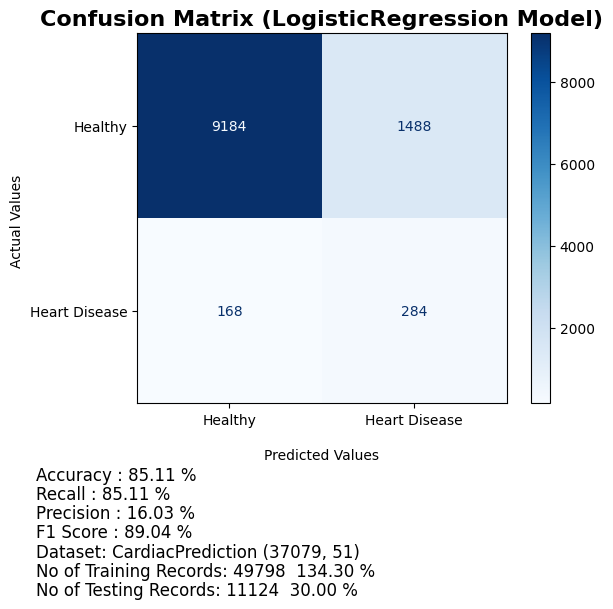

In [6]:
#1.     Logistic Regression
#classifierLR = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, l1_ratio=None, max_iter=100,multi_class='warn', n_jobs=None, penalty='l2',random_state=0, solver='liblinear', tol=0.0001, verbose=0,warm_start=False)
classifierLR = LogisticRegression(solver='liblinear', random_state=0)
#classifierLR = LogisticRegression()
classifierLR.fit(X_train, y_train)
predicted_LR = classifierLR.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifierLR.score(X_test, y_test)))

methodName = "LogisticRegression" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_LR)  
makeConfusionMatrixPicWithProbibality(1, methodName, dataSetName, classifierLR , X_test, y_test, predicted_LR)
#makeSHAPreport(methodName, classifierLR)
#makeSHAP_KERNELreport(methodName, classifierLR)
#makeLIMEreport(methodName, classifierLR)

 

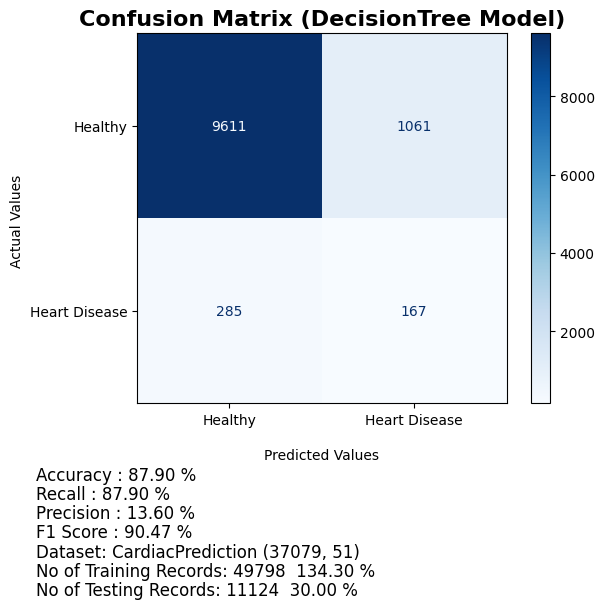

Accuracy: 0.8790003595828838


In [7]:
#2.     Decision Trees
classifierDT = DecisionTreeClassifier() 
classifierDT.fit(X_train, y_train) 
predicted_DT = classifierDT.predict(X_test)


methodName = "DecisionTree" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_DT)  
makeConfusionMatrixPicWithProbibality(2, methodName, dataSetName, classifierDT , X_test, y_test, predicted_DT)
#makeSHAPreport(methodName, classifierDT)
#makeSHAP_KERNELreport(methodName, classifierDT)
#makeLIMEreport(methodName, classifierDT)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_DT)
print("Accuracy:", accuracy)

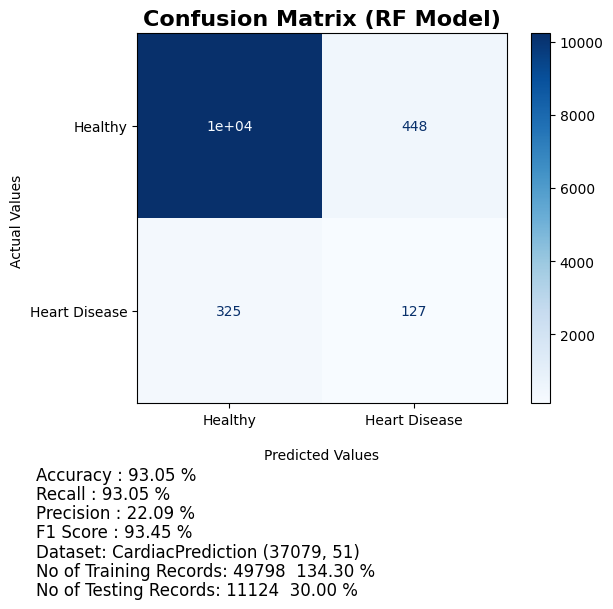

'\nconfusionM_rf = confusion_matrix(y_test, y_PredictionRF)\nprint(" Random Forest Accuracy:", accuracy_score(y_test, y_PredictionRF))\nprint(" Random Forest ConfusionM: ", confusionM_rf)\nprint(" Random Forest  length of estimators:{}".format(len(classifierRF.estimators_)))\n\n\nfolderPath = r\'./RandomForestTrees_{}/\'.format(dataSetName)\nprint("FolderPath:{}".format(folderPath))\nif not os.path.isdir(folderPath):\n    os.makedirs(folderPath)\n\n#for indx in range(len(rfClassifier.estimators_)):\nfor indx in range(5):\n    tree = classifierRF.estimators_[indx]\n    dot_data = export_graphviz(tree, out_file=None, feature_names=classifierRF.feature_names_in_, rounded=True, precision=1)\n    graph = pydotplus.graph_from_dot_data(dot_data)\n    picturePath = "{}tree_{}.png".format(folderPath, indx)\n    graph.write_png(picturePath)\n    print("Random Forest Tree Picture Generated:: path:", picturePath)\n    #os.startfile(picturePath)\n'

In [8]:
#3.     Random Forests
classifierRF = RandomForestClassifier(n_estimators=100, random_state = 42)
classifierRF.fit(X_train, y_train)
y_PredictionRF = classifierRF.predict(X_test)

methodName = "RF" 
#plot_classification_report(methodName, dataSetName, y_test, y_PredictionRF)  
makeConfusionMatrixPicWithProbibality(3, methodName, dataSetName, classifierRF , X_test, y_test, y_PredictionRF)
#makeSHAPreport(methodName, classifierRF)
#makeSHAP_KERNELreport(methodName, classifierRF)
#makeLIMEreport(methodName, classifierRF)
  
'''
confusionM_rf = confusion_matrix(y_test, y_PredictionRF)
print(" Random Forest Accuracy:", accuracy_score(y_test, y_PredictionRF))
print(" Random Forest ConfusionM: ", confusionM_rf)
print(" Random Forest  length of estimators:{}".format(len(classifierRF.estimators_)))


folderPath = r'./RandomForestTrees_{}/'.format(dataSetName)
print("FolderPath:{}".format(folderPath))
if not os.path.isdir(folderPath):
    os.makedirs(folderPath)

#for indx in range(len(rfClassifier.estimators_)):
for indx in range(5):
    tree = classifierRF.estimators_[indx]
    dot_data = export_graphviz(tree, out_file=None, feature_names=classifierRF.feature_names_in_, rounded=True, precision=1)
    graph = pydotplus.graph_from_dot_data(dot_data)
    picturePath = "{}tree_{}.png".format(folderPath, indx)
    graph.write_png(picturePath)
    print("Random Forest Tree Picture Generated:: path:", picturePath)
    #os.startfile(picturePath)
'''


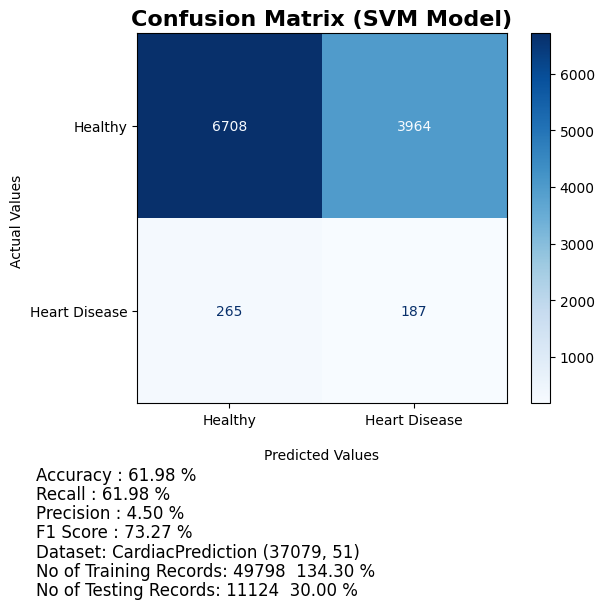

In [9]:
#4.     Support Vector Machines (SVM)
classifierSVM = SVC() #kernel = 'rbf', probability=True, random_state = 12)
#classifierSVM = SVC(kernel = 'rbf', probability=True)
#classifierSVM = SVC(C= 0.05, gamma=1/41, kernel='rbf', class_weight='balanced')

classifierSVM.fit(X_train, y_train)
y_PredictionSVM = classifierSVM.predict(X_test)

methodName = "SVM"
#plot_classification_report(methodName, dataSetName, y_test, y_PredictionSVM)  
makeConfusionMatrixPic(4, methodName, dataSetName, classifierSVM , X_test, y_test, y_PredictionSVM)
#makeSHAPreport(methodName, classifierSVM)
#makeSHAP_KERNELreport(methodName, classifierSVM)
#makeLIMEreport(methodName, classifierSVM)


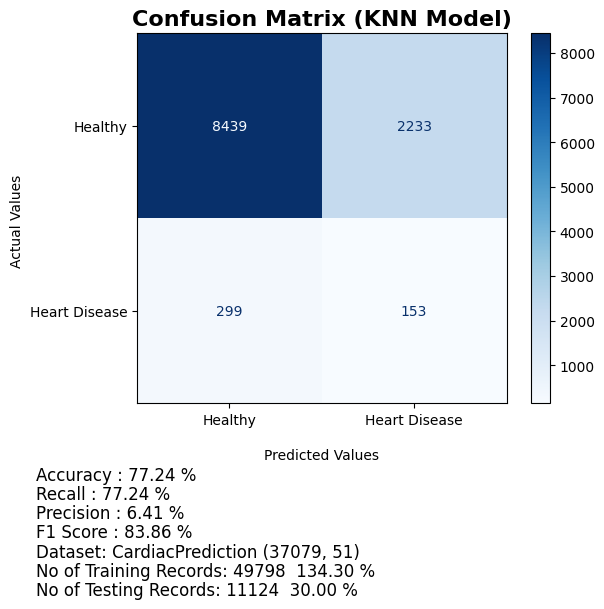

In [10]:
#5.     K-Nearest Neighbors (KNN)
classifierKNN = KNN(n_neighbors=3)
classifierKNN.fit(X_train, y_train)
y_PredictionKNN = classifierKNN.predict(X_test)

methodName = "KNN"
#plot_classification_report(methodName, dataSetName, y_test, y_PredictionKNN)  
makeConfusionMatrixPicWithProbibality(5, methodName, dataSetName, classifierKNN , X_test, y_test, y_PredictionKNN)
#makeSHAPreport(methodName, classifierKNN)
#makeSHAP_KERNELreport(methodName, classifierKNN)
#makeLIMEreport(methodName, classifierKNN)


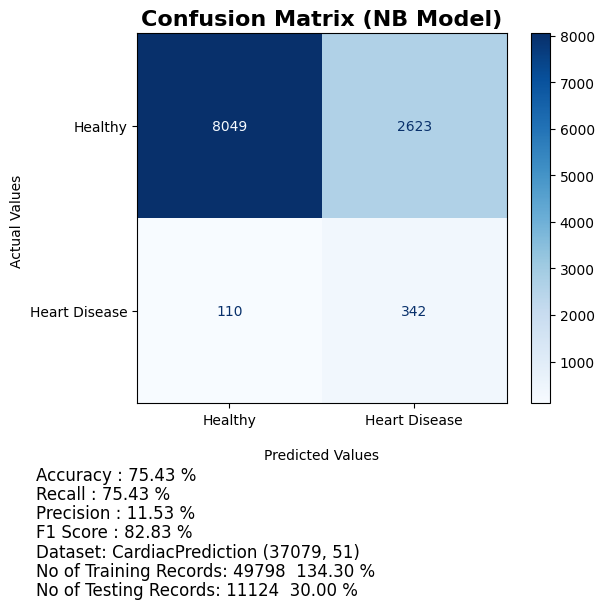

In [11]:
#6.     Naive Bayes (with appropriate modifications for numerical data, such as Gaussian Naive Bayes)
classifierNB = GaussianNB()
classifierNB.fit(X_train, y_train)
predicted_NB = classifierNB.predict(X_test)

methodName = "NB" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_NB)  
makeConfusionMatrixPicWithProbibality(6, methodName, dataSetName, classifierNB , X_test, y_test, predicted_NB)
#makeSHAPreport(methodName, classifierNB)
#makeSHAP_KERNELreport(methodName, classifierNB)
#makeLIMEreport(methodName, classifierNB)

X has feature names, but MLPClassifier was fitted without feature names


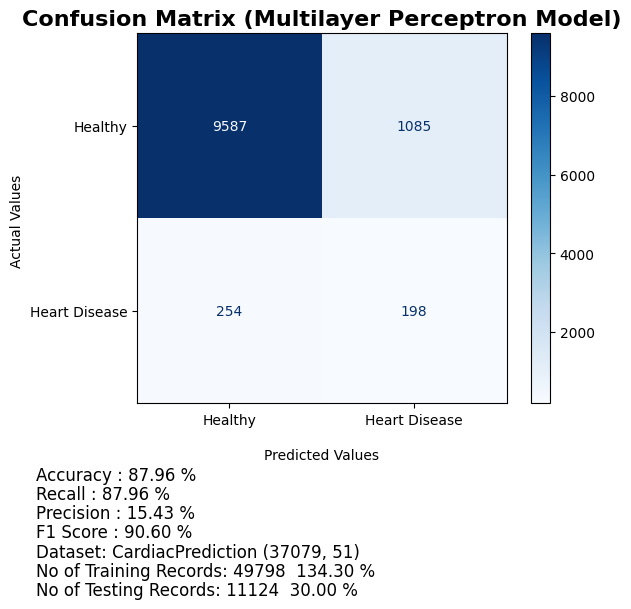

Accuracy: 0.8796296296296297


In [12]:
#7.     Neural Networks (e.g., Multilayer Perceptron)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)  # Adjust the hidden_layer_sizes and max_iter as desired
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)


methodName = "Multilayer Perceptron" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_AdaBoost)  
makeConfusionMatrixPicWithProbibality(7, methodName, dataSetName, mlp , X_test, y_test, y_pred)
#makeSHAPreport(methodName, classifierAdaBoost)
#makeSHAP_KERNELreport(methodName, classifierAdaBoost)
#makeLIMEreport(methodName, classifierAdaBoost)

accuracy = mlp.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

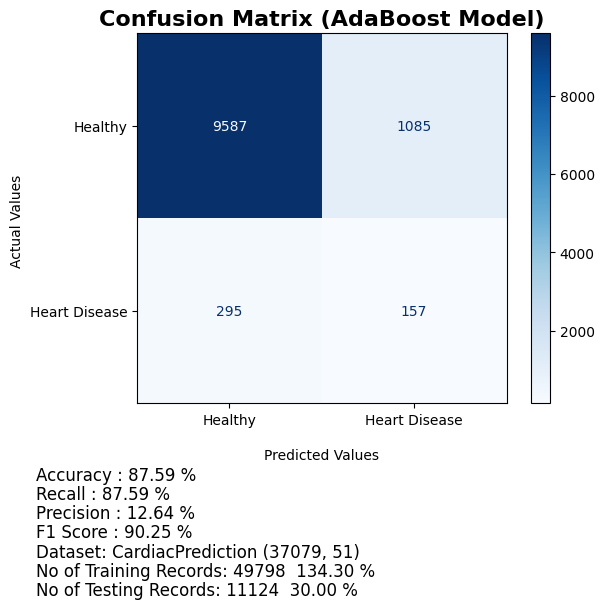

Accuracy: 0.8759439050701187


In [13]:
#8.     AdaBoost 
classifierAdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42) 
classifierAdaBoost.fit(X_train, y_train) 
predicted_AdaBoost = classifierAdaBoost.predict(X_test)


methodName = "AdaBoost" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_AdaBoost)  
makeConfusionMatrixPicWithProbibality(8, methodName, dataSetName, classifierAdaBoost , X_test, y_test, predicted_AdaBoost)
#makeSHAPreport(methodName, classifierAdaBoost)
#makeSHAP_KERNELreport(methodName, classifierAdaBoost)
#makeLIMEreport(methodName, classifierAdaBoost)
 
accuracy = accuracy_score(y_test, predicted_AdaBoost)
print("Accuracy:", accuracy)

In [14]:
#9.     Gaussian Processes
# Create a Gaussian Process classifier with RBF kernel
kernel = 1.0 * RBF(1.0)
#classifierGPC = GaussianProcessClassifier(kernel=kernel, random_state=42) 
classifierGPC = GaussianProcessClassifier() 
classifierGPC.fit(X_train, y_train) 
predicted_GPC = classifierGPC.predict(X_test)

methodName = "GaussianProcessClassifier" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_GPC)  
makeConfusionMatrixPic(9, methodName, dataSetName, classifierGPC , X_test, y_test, predicted_GPC)
#makeSHAPreport(methodName, classifierGPC)
#makeSHAP_KERNELreport(methodName, classifierGPC)
#makeLIMEreport(methodName, classifierGPC)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_GPC)
print("Accuracy:", accuracy)

MemoryError: Unable to allocate 9.24 GiB for an array with shape (1239895503,) and data type float64

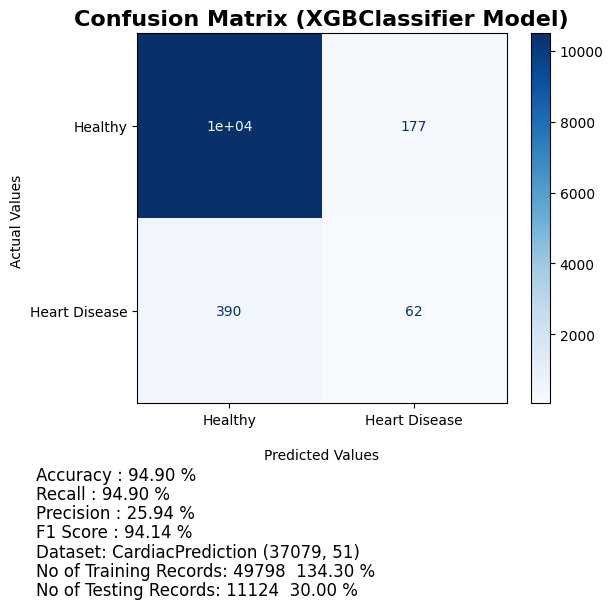

Accuracy: 0.9490291262135923


In [15]:
#10.     Extreme Gradient Boosting (XGBoost)
classifierXGB = xgb.XGBClassifier() 
classifierXGB.fit(X_train, y_train) 
predicted_XGB = classifierXGB.predict(X_test)

methodName = "XGBClassifier" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_XGB)  
makeConfusionMatrixPicWithProbibality(10, methodName, dataSetName, classifierXGB , X_test, y_test, predicted_XGB)
#makeSHAPreport(methodName, classifierXGB)
#makeSHAP_KERNELreport(methodName, classifierXGB)
#makeLIMEreport(methodName, classifierXGB)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_XGB)
print("Accuracy:", accuracy)

In [16]:
#11.     CatBoost
classifierCatBoost = CatBoostClassifier() 
classifierCatBoost.fit(X_train, y_train) 
predicted_CatBoost = classifierCatBoost.predict(X_test)

methodName = "CatBoostClassifier" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_CatBoost)  
makeConfusionMatrixPicWithProbibality(11, methodName, dataSetName, classifierCatBoost , X_test, y_test, predicted_CatBoost)
#makeSHAPreport(methodName, classifierCatBoost)
#makeSHAP_KERNELreport(methodName, classifierCatBoost)
#makeLIMEreport(methodName, classifierCatBoost)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_CatBoost)
print('Accuracy:', accuracy)


Learning rate set to 0.054657
0:	learn: 0.6432207	total: 212ms	remaining: 3m 31s
1:	learn: 0.5956114	total: 281ms	remaining: 2m 20s
2:	learn: 0.5559436	total: 312ms	remaining: 1m 43s
3:	learn: 0.5238237	total: 342ms	remaining: 1m 25s
4:	learn: 0.4936985	total: 371ms	remaining: 1m 13s
5:	learn: 0.4703294	total: 399ms	remaining: 1m 6s
6:	learn: 0.4507341	total: 430ms	remaining: 1m 1s
7:	learn: 0.4339417	total: 463ms	remaining: 57.4s
8:	learn: 0.4193880	total: 493ms	remaining: 54.3s
9:	learn: 0.4070039	total: 521ms	remaining: 51.6s
10:	learn: 0.3955579	total: 550ms	remaining: 49.4s
11:	learn: 0.3846528	total: 580ms	remaining: 47.8s
12:	learn: 0.3751058	total: 607ms	remaining: 46.1s
13:	learn: 0.3672127	total: 632ms	remaining: 44.5s
14:	learn: 0.3600691	total: 657ms	remaining: 43.1s
15:	learn: 0.3532795	total: 682ms	remaining: 41.9s
16:	learn: 0.3479676	total: 707ms	remaining: 40.9s
17:	learn: 0.3417744	total: 736ms	remaining: 40.2s
18:	learn: 0.3369804	total: 764ms	remaining: 39.5s
19:	le

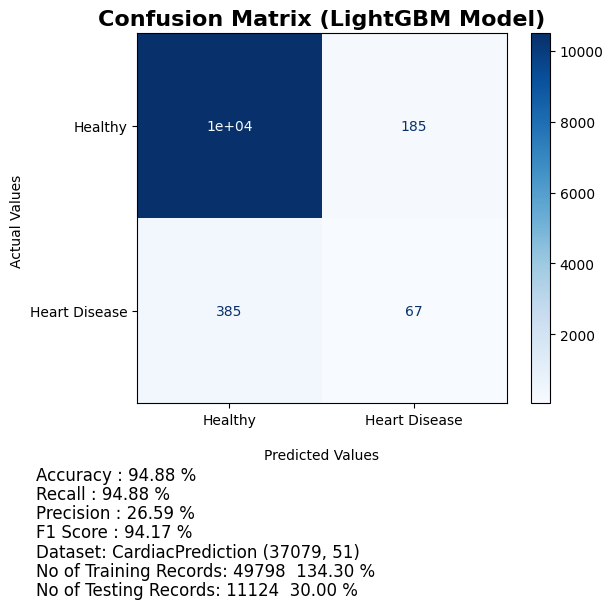

Accuracy: 0.9487594390507011


In [ ]:
#12.     LightGBM
classifierLGB = lgb.LGBMClassifier() 
classifierLGB.fit(X_train, y_train) 
predicted_LGB = classifierLGB.predict(X_test)
 
methodName = "LightGBM" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_LGB)  
makeConfusionMatrixPicWithProbibality(12, methodName, dataSetName, classifierLGB , X_test, y_test, predicted_LGB)
#makeSHAPreport(methodName, classifierLGB)
#makeSHAP_KERNELreport(methodName, classifierLGB)
#makeLIMEreport(methodName, classifierLGB)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_LGB)
print("Accuracy:", accuracy)

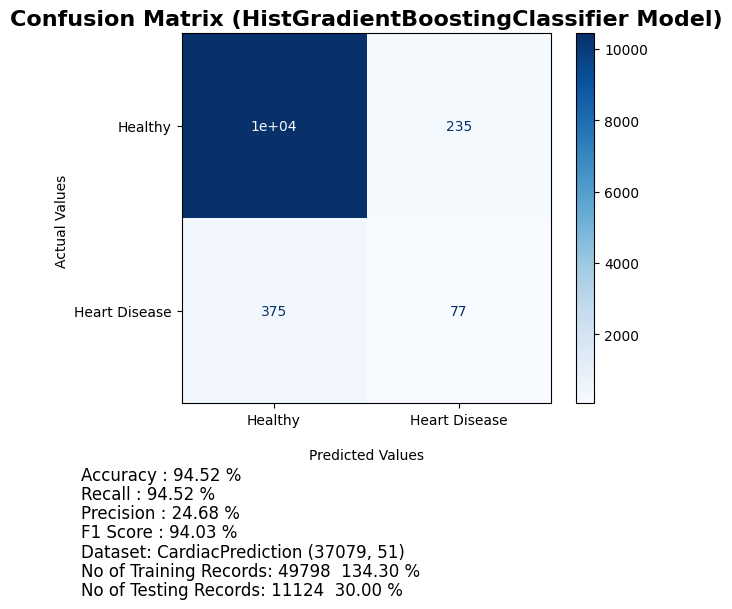

Accuracy: 0.9451636102121539


In [ ]:
#13.     Histogram-Based Gradient Boosting (HistGradientBoosting)
classifierHGB = HistGradientBoostingClassifier() 
classifierHGB.fit(X_train, y_train) 
predicted_HGB = classifierHGB.predict(X_test)

methodName = "HistGradientBoostingClassifier" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_HGB)  
makeConfusionMatrixPicWithProbibality(13, methodName, dataSetName, classifierHGB , X_test, y_test, predicted_HGB)
#makeSHAPreport(methodName, classifierHGB)
#makeSHAP_KERNELreport(methodName, classifierHGB)
#makeLIMEreport(methodName, classifierHGB)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_HGB)
print("Accuracy:", accuracy)

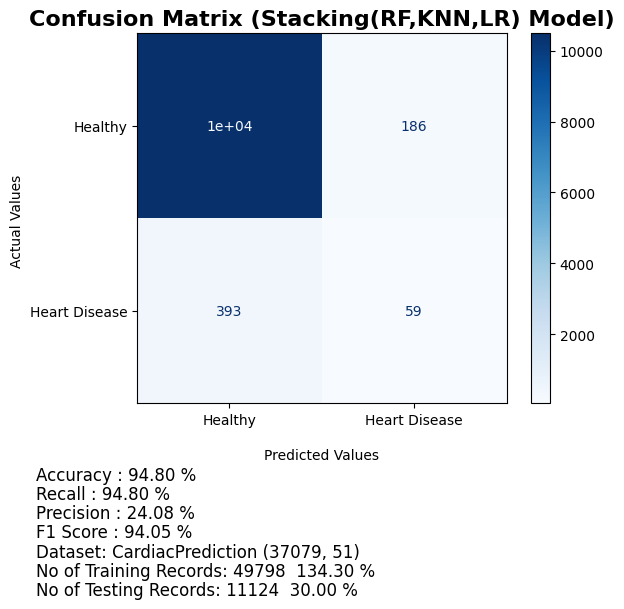

Accuracy: 0.947950377562028


In [ ]:
#14      Stacking: 
clf1 = RandomForestClassifier()
clf2 = KNN()
# Define the meta-classifier
meta_clf = LogisticRegression()
# Create the stacking classifier
classifierStacking = StackingClassifier(estimators=[('rf', clf1), ('knn', clf2)], final_estimator=meta_clf)
classifierStacking.fit(X_train, y_train) 
predicted_Stacking = classifierStacking.predict(X_test)

methodName = "Stacking(RF,KNN,LR)" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_Stacking)  
makeConfusionMatrixPicWithProbibality(14, methodName, dataSetName, classifierStacking , X_test, y_test, predicted_Stacking)
#makeSHAPreport(methodName, classifierStacking)
#makeSHAP_KERNELreport(methodName, classifierStacking)
#makeLIMEreport(methodName, classifierStacking)


# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_Stacking)
print("Accuracy:", accuracy)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


AttributeError: predict_proba is not available when voting='hard'

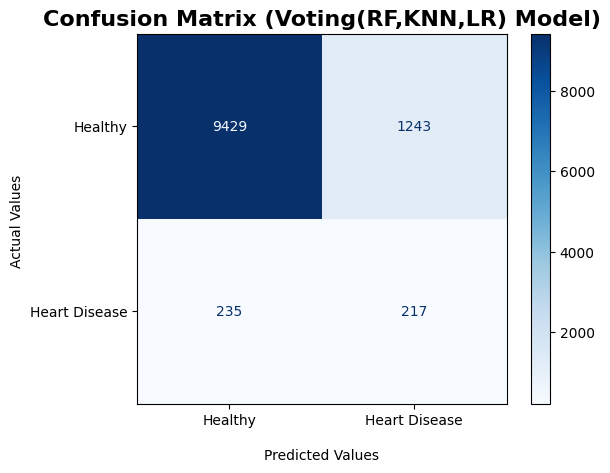

In [ ]:
#15      Voting: 
# Define the individual classifiers
clf1 = RandomForestClassifier()
clf2 = KNN()
clf3 = LogisticRegression()

# Create the voting classifier
classifierVoting = VotingClassifier(estimators=[('rf', clf1), ('knn', clf2), ('lr', clf3)], voting='hard')
# Train the voting classifier
classifierVoting.fit(X_train, y_train)
# Make predictions on the test set
predicted_Voting = classifierVoting.predict(X_test)

methodName = "Voting(RF,KNN,LR)" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_Voting)  
makeConfusionMatrixPic(15, methodName, dataSetName, classifierVoting , X_test, y_test, predicted_Voting)
#makeSHAPreport(methodName, classifierVoting)
#makeSHAP_KERNELreport(methodName, classifierVoting)
#makeLIMEreport(methodName, classifierVoting)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_Voting)
print("Accuracy:", accuracy)

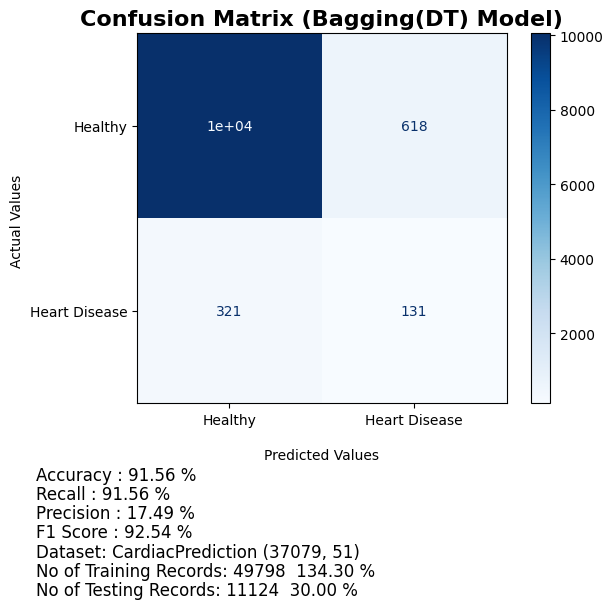

Accuracy: 0.9155879180151025


In [ ]:
#16      Bagging:
# Create a base classifier
base_clf = DecisionTreeClassifier() 
classifierBagging = BaggingClassifier(base_estimator=base_clf, n_estimators=10) 
classifierBagging.fit(X_train, y_train) 
predicted_Bagging = classifierBagging.predict(X_test)


methodName = "Bagging(DT)" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_Bagging)  
makeConfusionMatrixPicWithProbibality(16, methodName, dataSetName, classifierBagging , X_test, y_test, predicted_Bagging)
#makeSHAPreport(methodName, classifierBagging)
#makeSHAP_KERNELreport(methodName, classifierBagging)
#makeLIMEreport(methodName, classifierBagging)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_Bagging)
print("Accuracy:", accuracy)

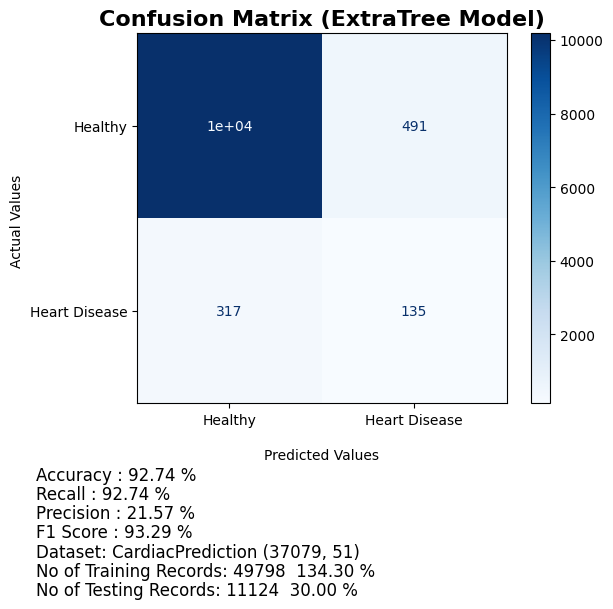

Accuracy: 0.9273642574613449


In [ ]:
#17      Extra Trees:  
classifierExtraTree = ExtraTreesClassifier(n_estimators=100) 
classifierExtraTree.fit(X_train, y_train) 
predicted_ExtraTree = classifierExtraTree.predict(X_test)

methodName = "ExtraTree" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_ExtraTree)  
makeConfusionMatrixPicWithProbibality(17, methodName, dataSetName, classifierExtraTree , X_test, y_test, predicted_ExtraTree)
#makeSHAPreport(methodName, classifierExtraTree)
#makeSHAP_KERNELreport(methodName, classifierExtraTree)
#makeLIMEreport(methodName, classifierExtraTree)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_ExtraTree)
print("Accuracy:", accuracy)

AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

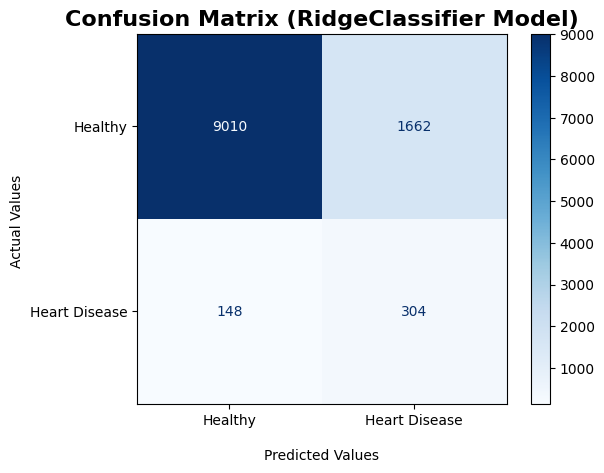

In [ ]:
#18      Ridge Classifier: 
classifierRidge = RidgeClassifier() 
classifierRidge.fit(X_train, y_train) 
predicted_Ridge = classifierRidge.predict(X_test)
 
methodName = "RidgeClassifier" 
#plot_classification_report(methodName, dataSetName, y_test, predicted_Ridge)  
makeConfusionMatrixPic(18, methodName, dataSetName, classifierRidge , X_test, y_test, predicted_Ridge)
#makeSHAPreport(methodName, classifierRidge)
#makeSHAP_KERNELreport(methodName, classifierRidge)
#makeLIMEreport(methodName, classifierRidge)


# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predicted_Ridge)
print("Accuracy:", accuracy)


total Rows: 15 -> Cols: 7


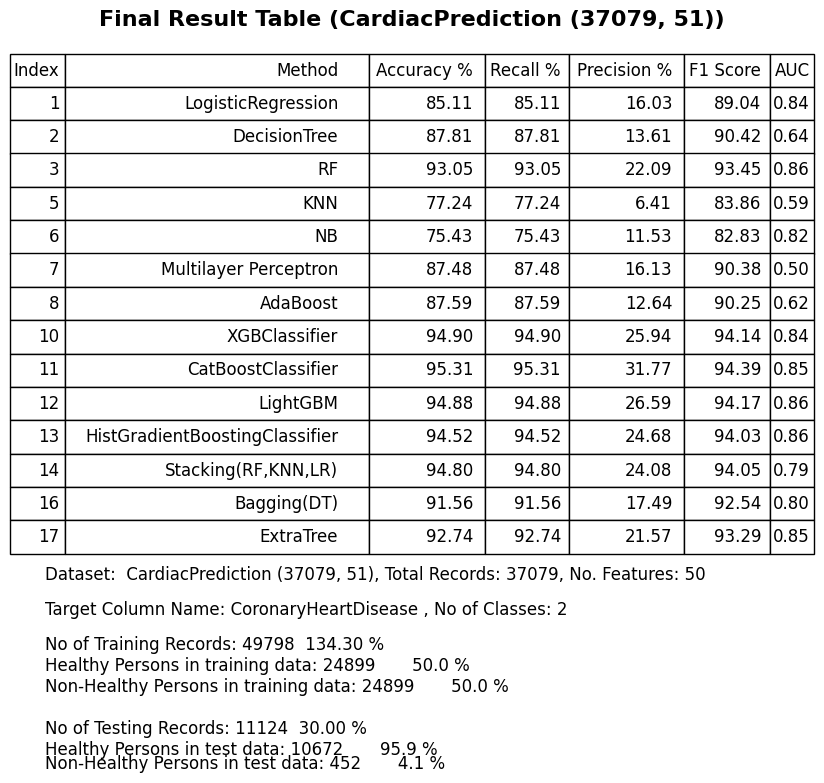

In [ ]:

# Determine the number of rows in the table (excluding the header)
num_rows = len(finalResultTable) - 1
print("total Rows: {} -> Cols: {}".format(len(finalResultTable), len(finalResultTable[0])))
# Calculate the desired figure size based on the number of rows
fig_width = 6  # Set the desired width of the figure
fig_height = num_rows * 0.5  # Adjust the scaling factor to control the height

fig, ax = mplot.subplots(figsize=(fig_width, fig_height)) 
table = mplot.table(cellText=finalResultTable, loc='center') 

table.auto_set_column_width(col=list(range(len(finalResultTable[0]))))
table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 

dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, X.__dataframe__().num_rows(), X.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(fileData[columns[-1]].value_counts()))
distributionOfTargetClassA = "No of Training Records: {}  {:.2f} %".format(len(X_train), ((len(X_train)/totalRecords) * 100.0))
 
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
classBrecords = "Healthy Persons in training data: {}       {:.1f} %".format(negativeClass, ((positiveClass/len(y_train)) * 100.0))
classArecords = "Non-Healthy Persons in training data: {}       {:.1f} %".format(positiveClass, ((positiveClass/len(y_train)) * 100.0))



positiveClassTest =  0
negativeClassTest = 0
for i in y_test:
    if(i == 0):
        negativeClassTest += 1
    if(i == 1):
        positiveClassTest += 1
classBrecordsTest = "Healthy Persons in test data: {}       {:.1f} %".format(negativeClassTest, ((negativeClassTest/len(y_test)) * 100.0))
classArecordsTest = "Non-Healthy Persons in test data: {}       {:.1f} %".format(positiveClassTest, ((positiveClassTest/len(y_test)) * 100.0))



distributionOfTargetClassB = "No of Testing Records: {}  {:.2f} %".format(len(X_test), ((len(X_test)/totalRecords) * 100.0))

fig.text(-0.1, +0.10,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.05,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, 0.00,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.03,  classBrecords, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.06,  classArecords, horizontalalignment='left', wrap=False , fontsize=12  )   

fig.text(-0.1, -0.12,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )  
fig.text(-0.1, -0.15,  classBrecordsTest, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.17,  classArecordsTest, horizontalalignment='left', wrap=False , fontsize=12  )   
 
mplot.axis('off')
mplot.title(f'Final Result Table ({dataSetName})' , fontsize=16, fontweight='bold') 
picturePath = "{}99.Final_Result_Table_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig(picturePath,  dpi=300)
mplot.show()
mplot.close()

In [ ]:

 
#fpr, tpr, thresholds = roc_curve(y_test, classifierLR.predict_proba(X_test)[:,1])
mplot.figure()
#mplot.plot(fpr, tpr, label="(area = {:.2f})".format(logit_roc_auc))

fprLR, tprLR, threshLR = roc_curve(y_test, classifierLR.predict_proba(X_test)[:,1])
#fprSVM, tprSVM, threshSVM = roc_curve(y_test, classifierSVM.predict_proba(X_test)[:,1])
fprKNN, tprKNN, threshKNN = roc_curve(y_test, classifierKNN.predict_proba(X_test)[:,1])
fprNB, tprNB, threshNB = roc_curve(y_test, classifierNB.predict_proba(X_test)[:,1])
 
    
# plotting    
mplot.plot(fprLR, tprLR, linestyle='--',color='green', label='Class 1 vs Rest')
#mplot.plot(fprSVM, tprSVM, linestyle='--',color='orange', label='Class 0 vs Rest')
mplot.plot(fprKNN, tprKNN, linestyle='--',color='blue', label='Class 2 vs Rest')
mplot.plot(fprNB, tprNB, linestyle='--',color='red', label='Class 2 vs Rest')
mplot.title('Multiclass ROC curve' ,fontsize=16, fontweight='bold')
mplot.xlabel('False Positive Rate')
mplot.ylabel('True Positive rate')
mplot.legend(loc='best')
mplot.savefig('Multiclass ROC',dpi=300);    
mplot.show

In [ ]:
roundValue = 0.0
for colName in fileData.__dataframe__().column_names():
    fileColData = fileData[colName].astype("int")
    roundValue = round(fileData[colName].mean(), 2)

    print("Column Name: {} -> MeanValue:{}".format(colName, roundValue))